
#Analise de Portfolio Usando PSO e GA


#Importações


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
# 4/5gEaQdg1o8WaNlhkHNCtalTOwtHj9EGVvLjXCdZQhe2SB_CgU9aRqVI

In [21]:
#para google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Optimização por enxame de partículas (Particle swarm optimization)

##Funcionamento:
 1. Gero uma População(grupo de individuos/particulas) Inicial com uma velocidade e posição
 2. Calculo a função fitness(para ver qual individuo é o melhor nesse problema de otimização de carteira) para cada individuo/particula
 3. Achar o pBest a melhor posição até o momento de cada particula
 4. Achar o gBest. O melhor individuo do bando que irá guiar as outras particulas
 5. Atualiza a velocidade(mudar a posição da particula) de cada particula.

 PS: em problemas complexos talvez seja necessário alterar o valor de x1 e x1 sendo que: x1 da mais preferencia a inteligencia individual e x2 aumenta o fator coletivo

 Eq da velocidade: 
                   x1 = random(0.0 a 1.0) * x1;
                   x2 = random(0.0 a 1.0) * x2

                   pBest = Melhor posição que a particula já teve
                   pAtual = Posição atual da particula
                   gBest = Melhor individuo do bando
                   vNova = velocidade nova
                            x1=inteligencia individual          x2=inteligencia coletiva
                   vNova = (pBest - pAtual) * x1 + (gBest - pAtual)*x2

Eq da Posição: posicaoNova = posicaoAntiga + Vnova


In [22]:
def pso_optimize(mean_daily_returns, cov_matrix):
    """
    Function for Particle Swarm Optimization
    """
    dimensions = 470 # dimensões - número de ações na carteira
    iterations = 3
    swarm_size = 500 # 500 partículas em enxame

    # Inicializando posições aleatórias para partículas no enxame
    swarm_position = []
    for particle in range(swarm_size):
        position = [0]*dimensions   # definir o tamanho do vetor de posição de uma partícula
        for dimension in range(dimensions):
            position[dimension] = random.random() # atribuir posição aleatória a uma partícula ao longo de todas as dimensões
        swarm_position.append(position)

    # Inicializando velocidades aleatórias para partículas no enxame
    swarm_velocity = []
    for particle in range(swarm_size):
        velocity = [0]*dimensions
        for dimension in range(dimensions):
            velocity[dimension] = random.random()
        swarm_velocity.append(velocity)

    swarm_position = np.array([np.array(p) for p in swarm_position])
    swarm_velocity = np.array([np.array(v) for v in swarm_velocity])
    particles_pbest = swarm_position # Inicializando pbest de todas as partículas
    swarm_gbest = particles_pbest[0] # Inicializando gbest

    avg_sharpe_list = []
    portfolio_return = []
    portfolio_vol = []
    portfolio_sharpe = []
    portfolio_weights = []

    for iteration in range(iterations):
        sharpe_pbest_all = []
        for particle in range(swarm_size):
            for dimension in range(dimensions):
                r1 = random.random()
                r2 = random.random()
                # Incorporando formas variantes no tempo de w, c1 e c2
                w = (0.9 - 0.4)*((iterations - iteration)/iterations) + 0.4 # w na iteração, onde initial_w = 0,9 & final_w = 0,4
                c1 = (0.5 - 2.5)*(iteration/iterations) + 2.5 # c1  na iteração, onde min_c1 = 0.5 & max_c1 = 2.5
                c2 = (2.5 - 0.5)*(iteration/iterations) + 0.5 # c2  na iteração, onde max_c2 = 2.5 & min_c2 = 0.5

                swarm_velocity[particle][dimension] = w * swarm_velocity[particle][dimension] + c1 * r1 * np.linalg.norm(particles_pbest[particle][dimension] - swarm_position[particle][dimension]) + c2 * r2 * np.linalg.norm(swarm_gbest[dimension] - swarm_position[particle][dimension]) # Update velocity in every dimension
                swarm_position[particle][dimension] = swarm_position[particle][dimension] + swarm_velocity[particle][dimension] # Atualiza posição em todas as direçoes

            sharpe_pbest = sharpe(particles_pbest[particle], mean_daily_returns, cov_matrix) # Avaliando o sharpe da posição pbest existente
            if sharpe(swarm_position[particle], mean_daily_returns, cov_matrix) > sharpe_pbest: # A nova posição é melhor do que a posição pbest existente?
                particles_pbest[particle] = swarm_position[particle] # Atualize o pbest para a nova posição
                sharpe_pbest = sharpe(particles_pbest[particle], mean_daily_returns, cov_matrix) # Atualizar sharpe de pbest
            sharpe_pbest_all.append(sharpe_pbest) # Adicionar à lista de taxas de sharpe de todas as posições pbest

        if max(sharpe_pbest_all) > sharpe(swarm_gbest, mean_daily_returns, cov_matrix): # É a maior proporção de sharpe de todos os pbests melhor do que sharpe de gbest existente?
            max_index = sharpe_pbest_all.index(max(sharpe_pbest_all)) # Obtenha o índice da maior proporção de sharpe entre todos os pbests
            swarm_gbest = particles_pbest[max_index] # Atualizar gbest usando o índice recuperado

        avg_sharpe = sum(sharpe_pbest_all)/len(sharpe_pbest_all) # média das taxas de sharpe de todos os pbests para uma iteração particular
        avg_sharpe_list.append(avg_sharpe) # Adicionando proporção média de sharpe a uma lista no final de cada iteração
        portfolio_return, portfolio_vol, portfolio_sharpe, portfolio_weights = optimized_solution(iteration, swarm_gbest, mean_daily_returns, cov_matrix, portfolio_return, portfolio_vol, portfolio_sharpe, portfolio_weights)

    return avg_sharpe_list, portfolio_return, portfolio_vol, portfolio_sharpe, portfolio_weights

#Algoritimo Genético

In [23]:
def ga_optimize(mean_daily_returns, cov_matrix):
    """
    Funcao para o Algoritmo Genético
    """
    pop_size = 500
    dna_size = 470
    generations = 3
    crossover_rate = 0.85

    avg_sharpe_list = []
    portfolio_return = []
    portfolio_vol = []
    portfolio_sharpe = []
    portfolio_weights = []

    population = []
    for j in range(pop_size):
            ind = [0]*dna_size
            for i in range(dna_size):
                ind[i] = random.random()
            population.append(ind)

    for g in range(generations):
        pop_with_fitness = []
        for individual in population:
            fitness_val = sharpe(individual, mean_daily_returns, cov_matrix)
            pair = (individual, fitness_val)
            pop_with_fitness.append(pair)

        population = []

        for i in range(int(pop_size/2)): # Substituir toda a população por uma nova população por seleção proporcional de aptidão, cruzamento de ponto único e mutação
            # Selection
            ind1 = selection(pop_with_fitness)
            ind2 = selection(pop_with_fitness)

            # Crossover
            if random.random() < crossover_rate:
                child1, child2 = crossover(ind1, ind2)
                # Elitismo, mutação e aumento da população
                child1 = mutate(child1)
                child2 = mutate(child2)
                sh1 = sharpe(ind1, mean_daily_returns, cov_matrix)
                sh2 = sharpe(ind2, mean_daily_returns, cov_matrix)
                ch1 = sharpe(child1, mean_daily_returns, cov_matrix)
                ch2 = sharpe(child2, mean_daily_returns, cov_matrix)
                if sh1 > sh2: # ind1 é mais adequado que ind2
                    if ch1 > sh1: # child1 é mais adequado que ind1
                        population.append(child1)
                    else:
                        population.append(ind1)

                    if ch2 > sh1: # a criança 2 está mais em forma do que ind1
                        population.append(child2)
                    else:
                        population.append(ind1)

                else: # ind2 é mais adequado do que ind1
                    if ch1 > sh2:
                        population.append(child1)
                    else:
                        population.append(ind2)

                    if ch2 > sh2:
                        population.append(child2)
                    else:
                        population.append(ind2)
            else: # se o crossover não ocorreu
                population.append(ind1)
                population.append(ind2)


        ind_fitness_all = []
        for individual in population:
            ind_fitness = sharpe(individual, mean_daily_returns, cov_matrix)
            ind_fitness_all.append(ind_fitness)

        max_index = ind_fitness_all.index(max(ind_fitness_all))
        fittest_individual = population[max_index]

        avg_fitness = sum(ind_fitness_all)/len(ind_fitness_all)
        avg_sharpe_list.append(avg_fitness)
        portfolio_return, portfolio_vol, portfolio_sharpe, portfolio_weights = optimized_solution(g, fittest_individual, mean_daily_returns, cov_matrix, portfolio_return, portfolio_vol, portfolio_sharpe, portfolio_weights)

    return avg_sharpe_list, portfolio_return, portfolio_vol, portfolio_sharpe, portfolio_weights

##Seleção do algoritmo genético

In [24]:
def selection(items):
    """
    Seleciona individuos da população para o cross over (Algoritmo Genético)
    """
    weight_total = sum((item[1] for item in items))
    n = random.uniform(0, weight_total)
    for item, weight in items:
        if n < weight:
            return item
        n = n - weight
    return item


##Cross Over

In [25]:
def crossover(male, female):
    """
    Cross over entre individuos selecionados
    """
    pos = int(random.random()*470)
    return (male[:pos] + female[pos:], female[:pos] + male[pos:])



##Mutação

In [26]:
def mutate(dna):
    """
    introduz a mutação para descendência produzida após o (Algoritmo Genético)
    """
    mutation_rate = 0.025
    dna_out = [0]*470
    for c in range(470):
        if random.random() < mutation_rate:
            dna_out[c] = random.random()
        else:
            dna_out[c] = dna[c]
    return dna_out

#Calculo Indice Sharp

In [27]:
def sharpe(weights, mean_daily_returns, cov_matrix):
    """
    Funcao que calcula o indice de sharp
    """
    weights = [w/sum(weights) for w in weights] # Certificando-se de que todos os pesos representam proporções que somam 1
    weights = np.matrix(weights)
    port_return = np.round(np.sum(weights * mean_daily_returns.T) * 1259, 2)/5 # 1259 dias de negociação durante um período de 5 anos
    port_std_dev = np.round(np.sqrt(weights * cov_matrix * weights.T) * np.sqrt(1259), 2)/np.sqrt(5)
    port_std_dev = float(port_std_dev)
    sharpe_ratio = (port_return - 2.57)/ port_std_dev # 2,57 representa o retorno anual do título sem risco - Tesouro dos EUA de 5 anos

    return sharpe_ratio

#Metodo para Otimizar os Algoritmos


In [28]:
def optimized_solution(i, weights, mean_daily_returns, cov_matrix, portfolio_return, portfolio_vol, portfolio_sharpe, portfolio_weights):
    """
    Printing optimized solution at the end of each iteration
    """
    weights = [w/sum(weights) for w in weights] # Certificando-se de que todos os pesos representam proporções que somam 1
    weights = np.matrix(weights)
    port_return = np.round(np.sum(weights * mean_daily_returns.T) * 1259, 2)/5 # 1259 dias de negociação durante um período de 5 anos
    port_std_dev = np.round(np.sqrt(weights * cov_matrix * weights.T) * np.sqrt(1259), 2)/np.sqrt(5)
    port_std_dev = float(port_std_dev)
    sharpe_ratio = (port_return - 2.57)/ port_std_dev # 2,57 representa o retorno anual do título sem risco - Tesouro dos EUA de 5 anos

    print("Iteracao: ", i)
    print("Retorno do Portfolio: ", port_return)
    print("Risco do Portfolio : ", port_std_dev)
    print("Indice Sharp do Portfolio", sharpe_ratio)

    portfolio_return.append(port_return) # Adicionar o retorno do portfólio de uma determinada solução a uma lista de retornos para todas as soluções
    portfolio_vol.append(port_std_dev) # Adicionando o desvio padrão do portfólio de uma determinada solução a uma lista de desvios padrão para todas as soluções
    portfolio_sharpe.append(sharpe_ratio)
    portfolio_weights.append(weights)

    return portfolio_return, portfolio_vol, portfolio_sharpe, portfolio_weights

#MAIN

pso or ga: pso
Iteracao:  0
Retorno do Portfolio:  14.252
Risco do Portfolio :  12.62931193691881
Indice Sharp do Portfolio 0.9249910096725407
Iteracao:  1
Retorno do Portfolio:  14.424000000000001
Risco do Portfolio :  12.651672616693808
Indice Sharp do Portfolio 0.9369512126292864
Iteracao:  2
Retorno do Portfolio:  14.478
Risco do Portfolio :  12.64720048073881
Indice Sharp do Portfolio 0.9415522445568422
Iteracao:  3
Retorno do Portfolio:  14.5
Risco do Portfolio :  12.64720048073881
Indice Sharp do Portfolio 0.9432917599565944
Iteracao:  4
Retorno do Portfolio:  14.508000000000001
Risco do Portfolio :  12.64720048073881
Indice Sharp do Portfolio 0.9439243110110499


Max sharpe indc:  0.9439243110110499
Otimizado Returno:  4    14.508
Name: Retornos, dtype: float64
Otimizado Risco:  4    12.6472
Name: Volatilidade, dtype: float64
Otimizado Pesos:
[[0.00297951 0.00155488 0.00287823 0.00124225 0.0015981  0.00247917
  0.00212135 0.00214797 0.00081415 0.00130572 0.00228876 0.00320542
 

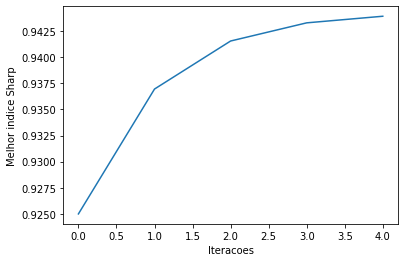

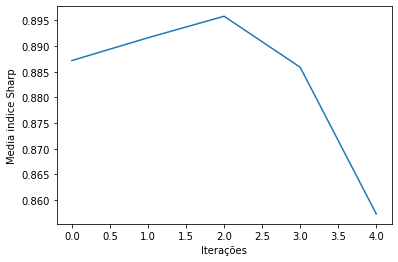

In [34]:
random.seed(1234)
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/TCC/S&P_data_modified.csv")
stock_counter = 1
mean_daily_returns = []
cov_input = []

#no 
while stock_counter <= 470:
    indv_stock = data[data.Stock_No == stock_counter]
    avg_return = indv_stock.Daily_Returns.mean()
    mean_daily_returns.append(avg_return)
    cov_input.append(indv_stock.Daily_Returns.tolist())
    stock_counter += 1
    #print(indv_stock)
    

mean_daily_returns = np.matrix(mean_daily_returns)
cov_input = np.matrix(cov_input)
cov_matrix = np.cov(cov_input)

choice = input("pso or ga: ")

while (choice != "pso" and choice != "ga"):
    print("Invalid input, please try again")
    choice = input("pso or ga: ")

if choice == "pso":
    avg_sharpe_list, portfolio_return, portfolio_vol, portfolio_sharpe, portfolio_weights = pso_optimize(mean_daily_returns, cov_matrix)
elif choice == "ga":
    avg_sharpe_list, portfolio_return, portfolio_vol, portfolio_sharpe, portfolio_weights = ga_optimize(mean_daily_returns, cov_matrix)


portfolios = {'Retornos': portfolio_return,
                'Volatilidade': portfolio_vol,
                'Indice Sharp': portfolio_sharpe,
                'Pesos': portfolio_weights}
portfolios_df = pd.DataFrame(portfolios)

averages = {'Media indice Sharp': avg_sharpe_list}
averages_df = pd.DataFrame(averages)

max_sharpe = portfolios_df['Indice Sharp'].max()
print("\n\nMax sharpe indc: ", max_sharpe)

optimal_portfolio = portfolios_df.loc[portfolios_df['Indice Sharp'] == max_sharpe]
print("Otimizado Returno: ", optimal_portfolio.Retornos)
print("Otimizado Risco: ", optimal_portfolio.Volatilidade)
print('Otimizado Pesos:')
for item in optimal_portfolio.Pesos:
    print(item)

portfolios_df['Indice Sharp'].plot()
plt.xlabel('Iteracoes')
plt.ylabel('Melhor indice Sharp')
plt.show()

averages_df['Media indice Sharp'].plot()
plt.xlabel('Iterações')
plt.ylabel('Media indice Sharp')
plt.show()

pso or ga: pso
Iteracao:  0
Retorno do Portfolio:  14.252
Risco do Portfolio :  12.62931193691881
Indice Sharp do Portfolio 0.9249910096725407
Iteracao:  1
Retorno do Portfolio:  14.424000000000001
Risco do Portfolio :  12.651672616693808
Indice Sharp do Portfolio 0.9369512126292864
Iteracao:  2
Retorno do Portfolio:  14.478
Risco do Portfolio :  12.64720048073881
Indice Sharp do Portfolio 0.9415522445568422
Iteracao:  3
Retorno do Portfolio:  14.5
Risco do Portfolio :  12.64720048073881
Indice Sharp do Portfolio 0.9432917599565944
Iteracao:  4
Retorno do Portfolio:  14.508000000000001
Risco do Portfolio :  12.64720048073881
Indice Sharp do Portfolio 0.9439243110110499


Max sharpe indc:  0.9439243110110499
Otimizado Returno:  4    14.508
Name: Retornos, dtype: float64
Otimizado Risco:  4    12.6472
Name: Volatilidade, dtype: float64
Otimizado Pesos:
[[0.00297951 0.00155488 0.00287823 0.00124225 0.0015981  0.00247917
  0.00212135 0.00214797 0.00081415 0.00130572 0.00228876 0.00320542
 

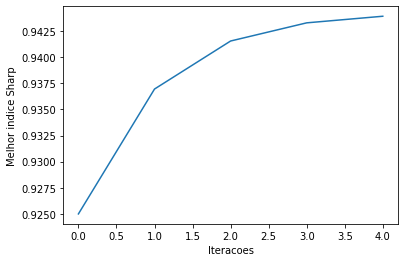

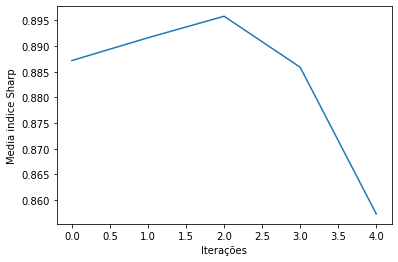

In [33]:
random.seed(1234)
data = pd.read_csv("/content/drive/My Drive/Colab Notebooks/TCC/S&P_data_modified.csv")
stock_counter = 1
mean_daily_returns = []
cov_input = []

#no 
while stock_counter <= 470:
    indv_stock = data[data.Stock_No == stock_counter]
    avg_return = indv_stock.Daily_Returns.mean()
    mean_daily_returns.append(avg_return)
    cov_input.append(indv_stock.Daily_Returns.tolist())
    stock_counter += 1
    #print(indv_stock)
    

mean_daily_returns = np.matrix(mean_daily_returns)
cov_input = np.matrix(cov_input)
cov_matrix = np.cov(cov_input)

choice = input("pso or ga: ")

while (choice != "pso" and choice != "ga"):
    print("Invalid input, please try again")
    choice = input("pso or ga: ")

if choice == "pso":
    avg_sharpe_list, portfolio_return, portfolio_vol, portfolio_sharpe, portfolio_weights = pso_optimize(mean_daily_returns, cov_matrix)
elif choice == "ga":
    avg_sharpe_list, portfolio_return, portfolio_vol, portfolio_sharpe, portfolio_weights = ga_optimize(mean_daily_returns, cov_matrix)


portfolios = {'Retornos': portfolio_return,
                'Volatilidade': portfolio_vol,
                'Indice Sharp': portfolio_sharpe,
                'Pesos': portfolio_weights}
portfolios_df = pd.DataFrame(portfolios)

averages = {'Media indice Sharp': avg_sharpe_list}
averages_df = pd.DataFrame(averages)

max_sharpe = portfolios_df['Indice Sharp'].max()
print("\n\nMax sharpe indc: ", max_sharpe)

optimal_portfolio = portfolios_df.loc[portfolios_df['Indice Sharp'] == max_sharpe]
print("Otimizado Returno: ", optimal_portfolio.Retornos)
print("Otimizado Risco: ", optimal_portfolio.Volatilidade)
print('Otimizado Pesos:')
for item in optimal_portfolio.Pesos:
    print(item)

portfolios_df['Indice Sharp'].plot()
plt.xlabel('Iteracoes')
plt.ylabel('Melhor indice Sharp')
plt.show()

averages_df['Media indice Sharp'].plot()
plt.xlabel('Iterações')
plt.ylabel('Media indice Sharp')
plt.show()